In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay


# Load Data
data = pd.read_csv("Employee Data.csv")
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (10000, 10)


,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,Female,Single,55122.97,Part-time,West,No,1.5,0
1,10002,50,Female,Single,89549.66,Full-time,West,Yes,12.8,1
2,10003,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8,0
3,10004,64,Female,Married,53877.83,Full-time,Northeast,No,3.3,0
4,10005,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employee_id      10000 non-null  int64  
 1   age              10000 non-null  int64  
 2   gender           10000 non-null  object 
 3   marital_status   10000 non-null  object 
 4   salary           10000 non-null  float64
 5   employment_type  10000 non-null  object 
 6   region           10000 non-null  object 
 7   has_dependents   10000 non-null  object 
 8   tenure_years     10000 non-null  float64
 9   enrolled         10000 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 781.4+ KB


employee_id        0
age                0
gender             0
marital_status     0
salary             0
employment_type    0
region             0
has_dependents     0
tenure_years       0
enrolled           0
dtype: int64

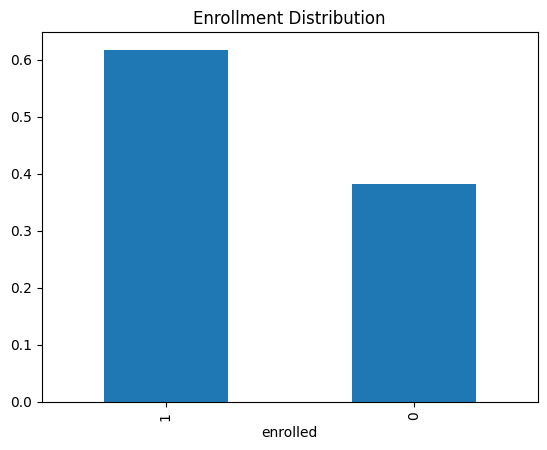

In [3]:
# target distribution
data['enrolled'].value_counts(normalize=True).plot(kind='bar', title='Enrollment Distribution')

# Data info
data.info()

# Missing values check
data.isnull().sum()

In [4]:

X = data.drop(columns=['enrolled', 'employee_id'])  # drop ID and target
y = data['enrolled']

#  Check unique values 
for col in ['gender', 'marital_status', 'employment_type', 'region', 'has_dependents']:
    print(f"{col}: {X[col].unique()}")

gender: ['Female' 'Male' 'Other']
marital_status: ['Single' 'Divorced' 'Married' 'Widowed']
employment_type: ['Part-time' 'Full-time' 'Contract']
region: ['West' 'Midwest' 'Northeast' 'South']
has_dependents: ['No' 'Yes']


In [5]:
#   80-20 split with stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (8000, 8), Test size: (2000, 8)


In [6]:
#  Define column types
numerical_cols = ['age', 'salary', 'tenure_years']
categorical_cols = ['gender', 'marital_status', 'employment_type', 'region', 'has_dependents']

#  Numerical pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

#  (Logistic Regression baseline)
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'salary',
                                                   'tenure_years']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'marital_status',
                                                   'employment_type', 'region',
                                                   'has_dependents'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [7]:
# Print feature names after preprocessing
feature_names = clf_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"Model sees {len(feature_names)} features: \n", feature_names)

Model sees 19 features: 
 ['num__age' 'num__salary' 'num__tenure_years' 'cat__gender_Female'
 'cat__gender_Male' 'cat__gender_Other' 'cat__marital_status_Divorced'
 'cat__marital_status_Married' 'cat__marital_status_Single'
 'cat__marital_status_Widowed' 'cat__employment_type_Contract'
 'cat__employment_type_Full-time' 'cat__employment_type_Part-time'
 'cat__region_Midwest' 'cat__region_Northeast' 'cat__region_South'
 'cat__region_West' 'cat__has_dependents_No' 'cat__has_dependents_Yes']


              precision    recall  f1-score   support

           0       0.84      0.90      0.87       765
           1       0.93      0.89      0.91      1235

    accuracy                           0.89      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.90      0.89      0.90      2000

ROC-AUC Score: 0.9706


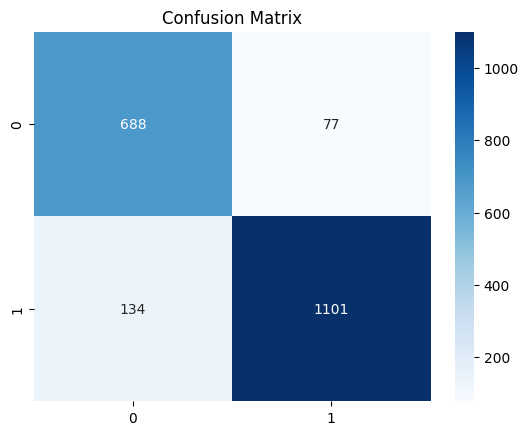

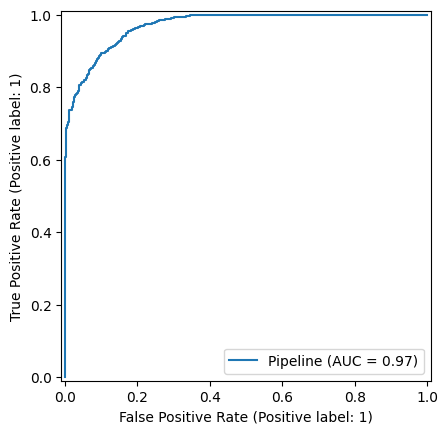

In [8]:
#  Predict
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf_pipeline, X_test, y_test)
plt.show()

# Trying with XG Boost 

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib

#most of the process is same as the previous one, not elaborating hence

data = pd.read_csv("Employee Data.csv")


X = data.drop(['employee_id', 'enrolled'], axis=1)
y = data['enrolled']

# Split Data Before Any Preprocessing (prevents leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Categorical Columns
cat_cols = ['gender', 'marital_status', 'employment_type', 'region', 'has_dependents']

#  Convert Categorical Columns to 'category' dtype
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

#model training 
model = XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

joblib.dump(model, "xgb.joblib")
print("Model saved")


Accuracy: 0.9995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       765
           1       1.00      1.00      1.00      1235

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 0.9999989415469291
Model saved


as the accuracy is almost 99% i am trying to find out chances of overfitting and data leak, the below given codes are methods which I used to figure it out. nothing of that sort was found. the data is small and can hence be 99% accurate. 

Correlation with 'enrolled':
 enrolled        1.000000
salary          0.366403
age             0.268749
employee_id     0.015004
tenure_years   -0.007480
Name: enrolled, dtype: float64


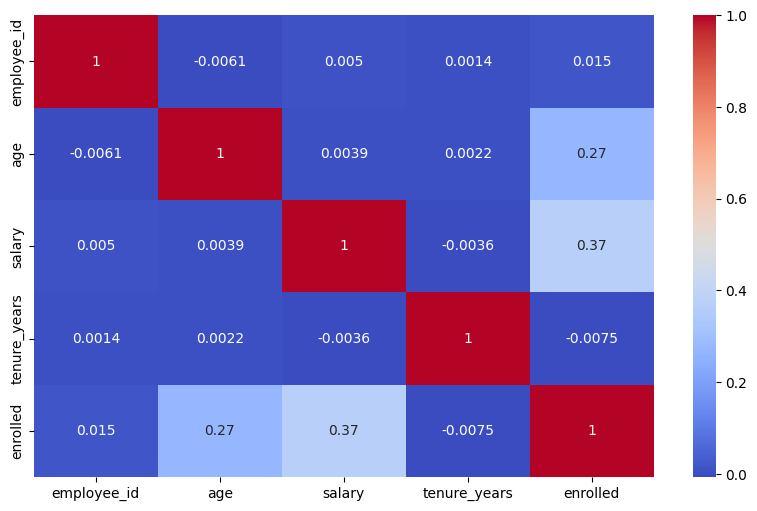

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


corrs = data.corr(numeric_only=True)
print("Correlation with 'enrolled':\n", corrs['enrolled'].sort_values(ascending=False))


plt.figure(figsize=(10,6))
sns.heatmap(corrs, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
print(data['enrolled'].value_counts()) # checking number of +ve and -ve value counts in datasets (Y)


enrolled
1    6174
0    3826
Name: count, dtype: int64


In [12]:
print("Number of duplicate rows:", data.duplicated().sum())


Number of duplicate rows: 0


In [13]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")


employee_id: 10000 unique values
age: 43 unique values
gender: 3 unique values
marital_status: 4 unique values
salary: 9988 unique values
employment_type: 3 unique values
region: 4 unique values
has_dependents: 2 unique values
tenure_years: 241 unique values
enrolled: 2 unique values


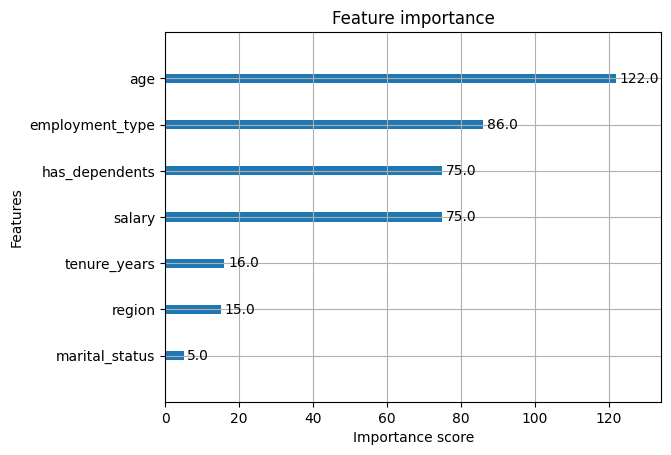

In [14]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10)
plt.show()


# cross validation 

In [ ]:

cat_cols = ['gender', 'marital_status', 'employment_type', 'region', 'has_dependents']


for col in cat_cols:
    X[col] = X[col].astype('category')

from sklearn.model_selection import cross_val_score

# cross-validation
scores = cross_val_score(
    model, X, y, cv=5, scoring='accuracy'
)
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [1.     0.9995 1.     1.     0.9995]
Mean accuracy: 0.9998000000000001


In [ ]:
import joblib


model = joblib.load("xgb.joblib")

# single test example
single_point = X_test.iloc[[0]].copy()
for col in cat_cols:
    single_point[col] = single_point[col].astype('category')

# Prediction
pred = model.predict(single_point)[0]
prob = model.predict_proba(single_point)[0][1]

# Compare with actual
actual = y_test.iloc[0]

print(f"Predicted class: {pred}")
print(f"Predicted probability of enrollment: {prob:.4f}")
print(f"Actual enrollment: {actual}")


Predicted class: 0
Predicted probability of enrollment: 0.0000
Actual enrollment: 0
